# Sign-up Rates A/B Testing

---

## Business Problem

The team is considering changing the color of the email sign-up button on the website's launch-page to potentially increase sign-up rates. The hypothesis is that the new colour may positively impact user engagement. To validate this, the product manager is proposing an A/B test to determine whether the colour change leads to a meaningful improvement and is the right move to implement.

## Hypothesis

### Null Hypothesis (H₀)
There is no statistically significant difference in email sign-up rates between the green (treatment) and blue (control) buttons.

### Alternative Hypothesis (H₁)
There is a statistically significant difference in email sign-up rates between the green and blue buttons — meaning that changing the button colour may increase or decrease sign-up rates.

## Data Source

The data comes from Site ABC's launch-page and is categorized into two main datasets:

* **Pretest Data (Control):** Collected data form Site ABC's launch-page pre A/B test. This dataset is used for A/A  and other validity tests to ensure there are no significant differences in email sign-up rates within the control group. Additionally, it is used to explore the data before the test.

* **Test Data (Treatment):** Collected from Site ABC's launch-page during the A/B test.

Table of Contents
=================

1. [The Data](#The-Data)
2. [Exploratory Data Analysis (EDA): Pretest](#Exploratory-Data-Analysis-(EDA):-Pretest)
3. [State The Hypothesis & Set The Parameters](#State-The-Hypothesis-&-Set-The-Parameters)
4. [Design The Experiment](#Design-The-Experiment)
    - [Calculate Sample Size](#Calculate-Sample-Size)
    - [Experiment Duration](#Experiment-Duration)
6. [Run The Experiment & Test Validity](#Run-The-Experiment-&-Test-Validity)
7. [AA Test](#AA-Test)
8. [Sample Ratio Mismatch](#Sample-Ratio-Mismatch)
9. [Chi-Squared Test](#Chi-Squared-Test)
11. [Z-Test](#Z-Test)
12. [Final Result w/ Confidence Interval](#Final-Result-w/-Confidence-Interval)
13. [Email Sign-Up A/B Test Summary: Site ABC Pre-Launch Page](#Email-Sign-Up-A/B-Test-Summary:-Site-ABC-Pre-Launch-Page)

In [253]:
from datetime import datetime
import random
import math

import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep, proportions_ztest

from warnings import filterwarnings
filterwarnings('ignore')

seed = 123
np.random.seed(seed)

## The Data

---

In [278]:
# Set data path and load data
pretest = pd.read_csv('Data/pretest.csv'); print('Pretest Data Imported!')
test = pd.read_csv('Data/test.csv'); print('Test Data Imported!')

# Set date fields as date_time
pretest['date'] = pd.to_datetime(pretest['date'])
test['date'] = pd.to_datetime(test['date'])

print(
    "\n",
    "------------------------------------ Pretest Data ------------------------------------",
    "\n",
)

pretest.info()
display(pretest.head(3))

print(
    "\n",
    "------------------------------------ Test Data ------------------------------------",
    "\n",
)

test.info()
display(test.head(3))

Pretest Data Imported!
Test Data Imported!

 ------------------------------------ Pretest Data ------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309903 entries, 0 to 309902
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   visitor_id  309903 non-null  int64         
 1   date        309903 non-null  datetime64[ns]
 2   email       31295 non-null   object        
 3   experiment  30039 non-null   object        
 4   group       30039 non-null   float64       
 5   submitted   309903 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 14.2+ MB


,visitor_id,date,email,experiment,group,submitted
0,1,2021-12-01,NaN,NaN,NaN,0
1,2,2021-12-01,NaN,NaN,NaN,0
2,3,2021-12-01,NaN,NaN,NaN,0



 ------------------------------------ Test Data ------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139959 entries, 0 to 139958
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   visitor_id  139959 non-null  int64         
 1   date        139959 non-null  datetime64[ns]
 2   email       14602 non-null   object        
 3   experiment  30081 non-null   object        
 4   group       139959 non-null  int64         
 5   submitted   139959 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 6.4+ MB


,visitor_id,date,email,experiment,group,submitted
0,1,2022-02-01,NaN,NaN,0,0
1,2,2022-02-01,villarrealcheryl@example.com,NaN,1,1
2,3,2022-02-01,NaN,NaN,0,0


#### Pretest Data:

This data set consists of pre A/B testing data, meaning this data consists of user data before the launch of the A/B test.

#### Test Data:

This data set consists of user data during the A/B test.

The test dataset is divided into two groups: **control** and **treatment**.  
- The **control group** consists of unique site visitors who were shown the blue button.  
- The **treatment group** includes unique site visitors who were shown the green button.  

Each row represents a unique visitor interaction, with the following columns:

* **visitor_id:** A unique identifier for each site visitor. All IDs are distinct, with no duplicates.
* **date:** The date the user visited the site and the data was recorded.
* **email:** Captures the email address submitted by the visitor. A missing value (NaN) indicates the user did not submit an email and therefore did not sign up.
* **experiment:** Indicates assigned to an experiment or not (null, A/A test, email_test (A/B test)).
* **group:** If the user was assigned to treatment or control (1 = treatment, 0 = control).
* **Submitted:** Marks whether the user submitted an email to sign-up (1 = submitted and email, 0 = did not submit an email).

## Exploratory Data Analysis (EDA): Pretest

---

In [9]:
print('# of rows:', pretest.shape[0])
print('Date range:', pretest.date.min(), '-', pretest.date.max())

# of rows: 309903
Date range: 2021-12-01 00:00:00 - 2021-12-31 00:00:00


The duration collected for the pretest data is from  **December 01, 2021 to December 31, 2021** (31 days).

In [11]:
# Null rate per column?
pretest.isnull().mean()

visitor_id    0.000000
date          0.000000
email         0.899017
experiment    0.903070
group         0.903070
submitted     0.000000
dtype: float64

The rates above show the proportion of null values in each column. Notably, the **email**, **experiment**, and **group** columns contain a high number of nulls. Approximately 90% of the total data points are missing values.

* **email:** Just over 10% of users submitted their email addresses.
* **experiment:** Around 10% of users were assigned to an experiment.
* **group:** About 10% of users were assigned to a group as part of the experiment.

In [13]:
print('Total visitor count:', pretest.visitor_id.nunique())
print('Sign-up count:', pretest.submitted.sum())
print('Sign-up rate:', pretest.submitted.mean().round(2))

Total visitor count: 309903
Sign-up count: 31295
Sign-up rate: 0.1


Here we can further see that ~10% of users signed up with their emails totaling 31,295.

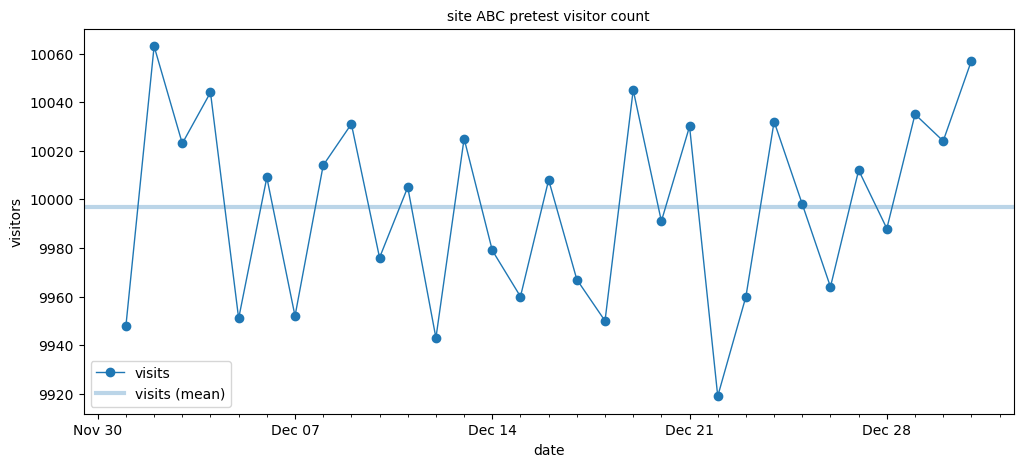

count       31.000000
mean      9996.870968
std         38.199251
min       9919.000000
25%       9962.000000
50%      10005.000000
75%      10027.500000
max      10063.000000
Name: submitted, dtype: float64

In [161]:
# Set the color palette for the plot
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

# Count sign-ups by date
visits_per_day = pretest.groupby('date')['submitted'].count()
visits_mean = visits_per_day.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(visits_per_day.index, visits_per_day, '-o', color=c1, linewidth=1, label='visits')
plt.axhline(visits_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='visits (mean)')

# Format plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('site ABC pretest visitor count', fontsize=10)
plt.ylabel('visitors', fontsize=10)
plt.xlabel('date', fontsize=10)
plt.legend()

plt.show()

visits_per_day.describe()

When examining total daily visits, we observe some volatility, with counts ranging from 9,919 to 10,063 and a standard deviation of 38. The overall average across all days is 9,997. Notably, there is a spike in visits around Christmas Day and Boxing Day—holiday effects.

In knowing the average visits per day of ~10k, this will help in determining the duration and sampling of the A/B test.

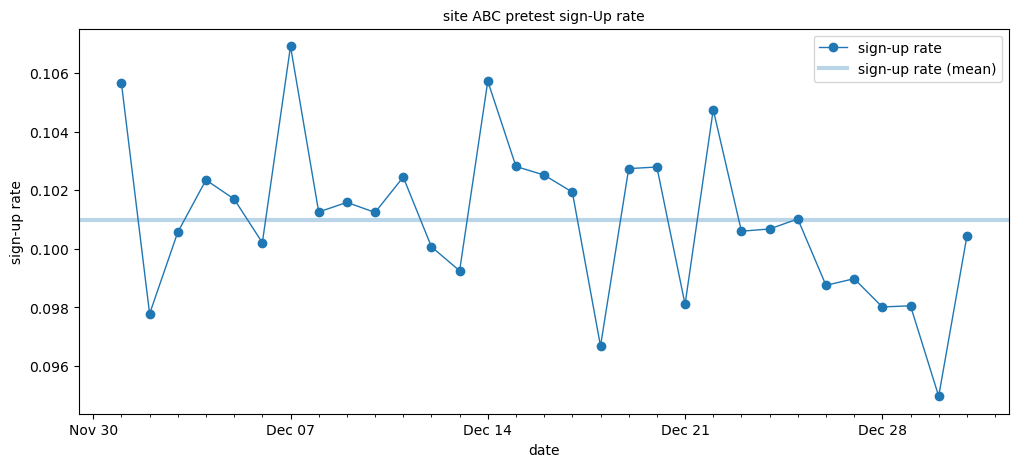

count    31.000000
mean      0.100987
std       0.002684
min       0.094972
25%       0.099117
50%       0.101020
75%       0.102483
max       0.106913
Name: submitted, dtype: float64

In [159]:
# Get the submission rate per date
signup_rate_per_day = pretest.groupby('date')['submitted'].mean() 
signup_rate_mean = signup_rate_per_day.mean() 

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(signup_rate_per_day.index, signup_rate_per_day, '-o', color=c1, linewidth=1, label='sign-up rate')
plt.axhline(signup_rate_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='sign-up rate (mean)')

# Format plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('site ABC pretest sign-Up rate', fontsize=10)
plt.ylabel('sign-up rate', fontsize=10)
plt.xlabel('date', fontsize=10)
plt.legend()
plt.show()

signup_rate_per_day.describe()

When looking at daily sign-up rates, we observe continued volatility, ranging from 9.5% to 10.2%, with a standard deviation of 0.2%. As expected, there's a noticeable difference during the holiday season. Interestingly, while visits increased during this period, sign-ups did not follow the same trend—likely contributing to the overall decline in sign-up rates during the holidays.

A key takeaway is that the average daily sign-up rate hovers around 10%. This baseline will serve as our reference point when determining the lift for the A/B test.

## State The Hypothesis & Set The Parameters

---

##### Null Hypothesis (H₀)
There is no statistically significant difference between the green and blue button variations in email sign-ups.

##### Alternative Hypothesis (H₁)
There is a statistically significant difference between the green and blue button variations in email sign-ups, meaning that changing the button colour from blue to green will increase or decrease email sign-ups.

In [24]:
# Experiment parameters
alpha = 0.05
power = 0.80 
mde = 0.10 

# Proportions if the effect exists
p1 = 0.10
p2 = p1 * (1 + mde)

* **alpha (α):** The significance level is set at 0.05. If the p-value falls below this threshold, we reject the null hypothesis (H₀). This also means that if H₀ is actually true, there's a 5% chance of incorrectly rejecting it — a **Type I error**.

* **power (1 - β):** The test is designed with 80% power, meaning there is an 80% chance of correctly detecting a true effect when one exists — that is, rejecting H₀ when it is false. Conversely, there is a 20% chance of a **Type II error (β)** — failing to reject H₀ even though it is false.

* **mde (Minimum Detectable Effect / Lift):** The smallest effect size (or lift) that the test is powered to detect with statistical significance. In this case, the test is designed to detect a **10% relative increase** over the baseline daily sign-up rate of 10% — meaning we aim to reliably detect a change from 10% to 11%.

* **p1 (control):** Control (Blue) - Baseline (10% sign-up rate).

* **p2 (treatment):** Treatment (Green) - p2 = 0.10 * 1.10 = 0.11 (or 11%).

## Design The Experiment

---

### Calculate Sample Size


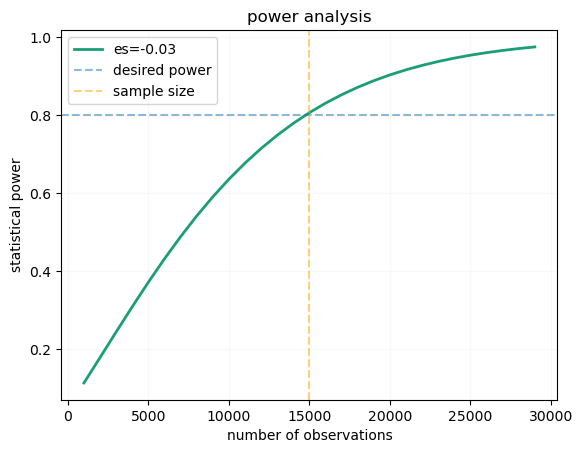

To detect an effect of 10.0% lift from the pretest sign-up at 10%,the sample size per group required is 15000.
The total sample required in the experiment is 30000.


In [175]:
# Calculate the effect size using Cohen's h - a standardized measure of the difference between two proportions
cohen_h = sm.stats.proportion_effectsize(p1, p2)

# Estimate the sample size required per group
n = tt_ind_solve_power(effect_size=cohen_h, power=power, alpha=alpha)
n = int(round(n, -3)) # Round up to the nearest thousand

# Explore power across sample sizes
ttest_power = TTestIndPower()
ttest_power.plot_power(dep_var='nobs', nobs=np.arange(1000,30000,1000), effect_size=[cohen_h], title='power analysis')

# Set plot parameters
plt.axhline(0.8, linestyle='--', label='desired power', alpha=0.5)
plt.axvline(n, linestyle='--', color='orange', label='sample size', alpha=0.5)
plt.ylabel('statistical power')
plt.xlabel('number of observations')
plt.grid(alpha=0.08)
plt.legend()
plt.show()

print(f'To detect an effect of {100*(p2/mde-1):.1f}% lift from the pretest sign-up at {100*p1:.0f}%,'f'the sample size per group required is {n}.')
print(f'The total sample required in the experiment is {2*n}.')

### Experiment Duration



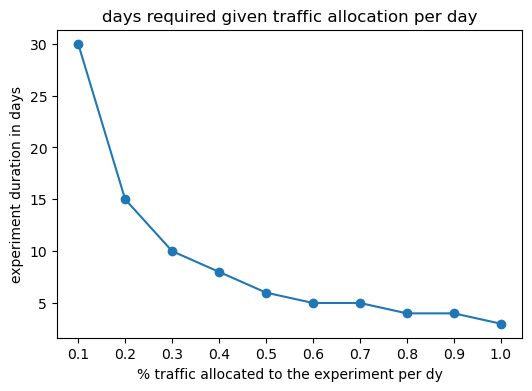

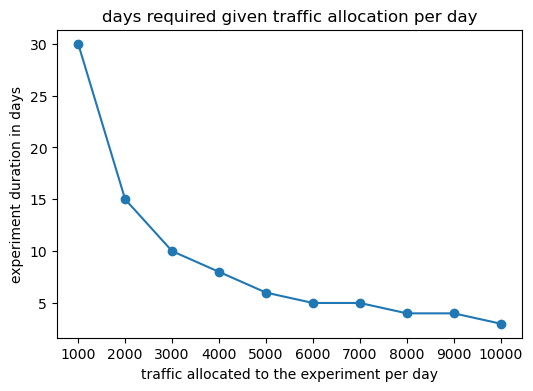

In [167]:
alloc = np.arange(0.10,1.1,0.10)
size = round(visits_mean, -3) * alloc
days = np.ceil(2*n / size)

# Generate plot
f, ax = plt.subplots(figsize=(6, 4))
ax.plot(alloc, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title('days required given traffic allocation per day')
ax.set_ylabel('experiment duration in days')
ax.set_xlabel('% traffic allocated to the experiment per dy')
plt.show()

f, ax = plt.subplots(figsize=(6, 4))
ax.plot(size, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.set_title('days required given traffic allocation per day')
ax.set_ylabel('experiment duration in days')
ax.set_xlabel('traffic allocated to the experiment per day')
plt.show()

In [165]:
# Display the number of users required per day in an experiment given the experiment duration.
print(f'For a 21-day experiment, {np.ceil((n * 2) / 21)} users are required per day') # Too long to wait
print(f'For a 14-day experiment, {np.ceil((n * 2) / 14)} users are required per day') # Sweet spot between risk and time
print(f'For a 7-day experiment, {np.ceil((n * 2) / 7)} users are required per day')   # Too risky

For a 21-day experiment, 1429.0 users are required per day
For a 14-day experiment, 2143.0 users are required per day
For a 7-day experiment, 4286.0 users are required per day


Ideally, the experiment should run for longer than 7 days due to the following factors:

* **Day-of-Week Effect:** User behavior often varies between weekdays and weekends, so testing across a full week ensures more representative results.

* **Novelty Effect:** Users may initially respond positively simply because something is new, which can temporarily inflate results and not reflect the long-term impact.

* **Change Aversion:** Conversely, users may initially resist a change — even if it is beneficial — leading to an early dip in performance. Allowing more time gives users a chance to adapt and provides a clearer picture of the true effect.

Likewise, extending the test beyond 14 days may slow down product optimization, as quicker insights are needed to drive timely improvements. As such, the expeiment wil run for a 14-day (two-week) duration for our A/B test. To meet the required sample size of 30,000 users, we will need approximately 2,143 unique users per day.

## Run The Experiment & Test Validity

---

In [191]:
# Get the subset tables of control and treatment results
AB_test = test.loc[test['experiment'] == 'email_test']
control_signups = AB_test.loc[AB_test['group'] == 0]['submitted']
treatment_signups = AB_test.loc[AB_test['group'] == 1]['submitted']

# Get stats 
AB_control_cnt = control_signups.sum()          # Control Sign-Up Count
AB_treatment_cnt = treatment_signups.sum()      # Treatment Sign-Up Count
AB_control_rate = control_signups.mean()        # Control Sign-Up Rate
AB_treatment_rate = treatment_signups.mean()    # Treatment Sign-Up Rate
AB_control_size = control_signups.count()       # Control Sample Size 
AB_treatment_size = treatment_signups.count()   # Treatment Sample Size

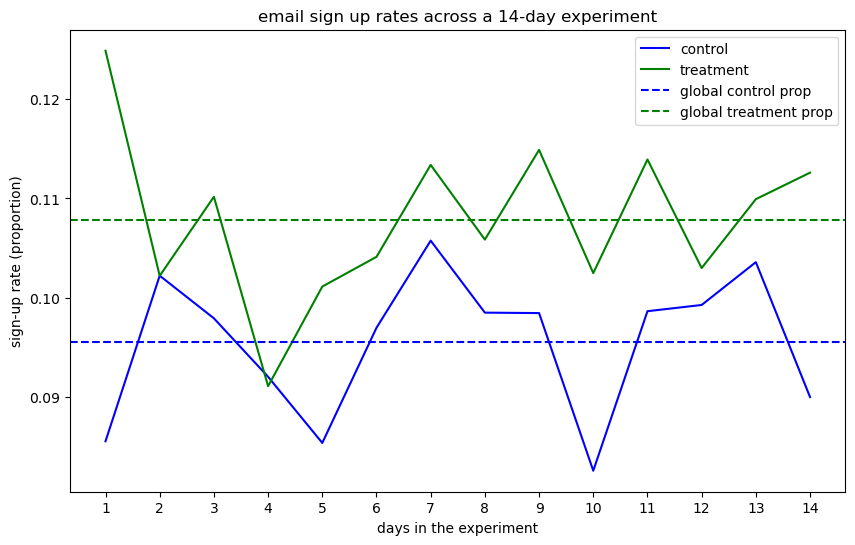

Control Sign-Up Rate: 0.09557
Treatment Sign-Up Rate: 0.1078


In [193]:
# Calculate the sign-up rates per date
signups_per_day = AB_test.groupby(['group','date'])['submitted'].mean()
ctrl_props = signups_per_day.loc[0]
trt_props = signups_per_day.loc[1]

# Get the day range of the experiment
exp_days = range(1, AB_test['date'].nunique() + 1)

# Let's display the sign-up rate per experiment day
f, ax = plt.subplots(figsize=(10, 6))
# Generate plots
ax.plot(exp_days, ctrl_props, label='control', color='b')
ax.plot(exp_days, trt_props, label='treatment', color='g')
ax.axhline(AB_control_rate, label='global control prop', linestyle='--', color='b')
ax.axhline(AB_treatment_rate, label='global treatment prop', linestyle='--', color='g')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('email sign up rates across a 14-day experiment')
ax.set_ylabel('sign-up rate (proportion)')
ax.set_xlabel('days in the experiment')
ax.legend()
plt.show()

# Show calculation
print(f'Control Sign-Up Rate: {AB_control_rate:.4}')
print(f'Treatment Sign-Up Rate: {AB_treatment_rate:.4}')

The clear and consistent separation between the control and treatment groups signals a difference in performance. It visually shows that the treatment may be driving an effect.

### A/A Test



In [201]:
# Filter on visitors in the AA test 
AA_test = pretest[pretest.experiment == 'AA_test']

# Grab the control and treatment groups in the AA test
AA_control = AA_test[AA_test.group == 0]['submitted']
AA_treatment = AA_test[AA_test.group == 1]['submitted']

# Get stats
AA_control_cnt = AA_control.sum()
AA_treatment_cnt = AA_treatment.sum()
AA_control_rate = AA_control.mean()
AA_treatment_rate = AA_treatment.mean()
AA_control_size = AA_control.count()
AA_treatment_size = AA_treatment.count()

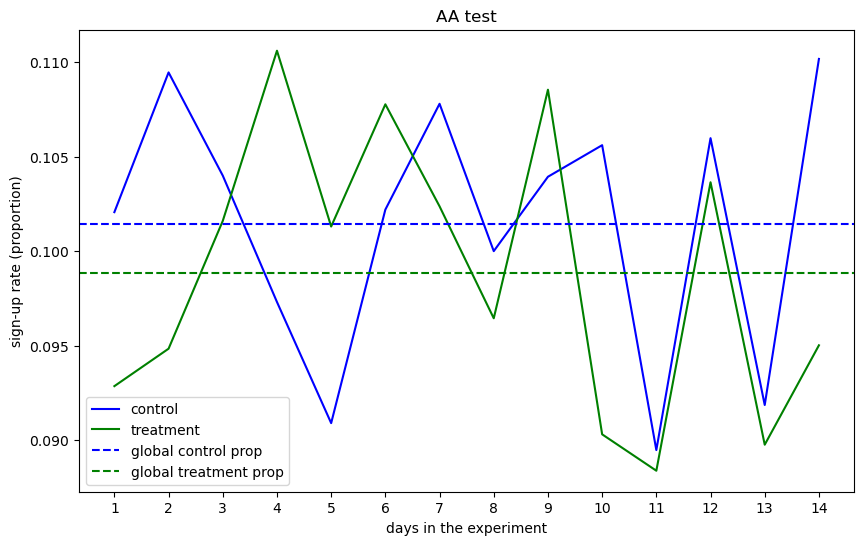

-------- AA Test ----------
Control Sign-Up Rate: 0.101
Treatment Sign-Up Rate: 0.0988


In [203]:
# Sign-up rates per date
AA_signups_per_day = AA_test.groupby(['group','date'])['submitted'].mean()
AA_ctrl_props = AA_signups_per_day.loc[0]
AA_trt_props = AA_signups_per_day.loc[1]

# Get the day range of experiment
exp_days = range(1, AA_test['date'].nunique() + 1)

# Let's display the sign-up rate per experiment day
f, ax = plt.subplots(figsize=(10, 6))
# Generate plots
ax.plot(exp_days, AA_ctrl_props, label='control', color='b')
ax.plot(exp_days, AA_trt_props, label='treatment', color='g')
ax.axhline(AA_control_rate, label='global control prop', linestyle='--', color='b')
ax.axhline(AA_treatment_rate, label='global treatment prop', linestyle='--', color='g')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('AA test')
ax.set_ylabel('sign-up rate (proportion)')
ax.set_xlabel('days in the experiment')
ax.legend()
plt.show()

# Show calculation
print('-------- AA Test ----------')
print(f'Control Sign-Up Rate: {AA_control_rate:.3}')
print(f'Treatment Sign-Up Rate: {AA_treatment_rate:.3}')

In this AA test, both the control and treatment groups receive similar sign-up rates. As expected, there is no clear or consistent separation between the groups over the 14-day period. The sign-up rates fluctuate around similar values, and the global averages are close. The above groups will be further test with a chi-squared below.

In [209]:
# Execute test
AA_chistats, AA_pvalue, AA_tab = proportions_chisquare([AA_control_cnt, AA_treatment_cnt], nobs=[AA_control_size, AA_treatment_size])

# Grab dates
first_date = AA_test['date'].min().date()
last_date = AA_test['date'].max().date()

# Set the ALPHA for the AA test
AA_ALPHA = 0.05

print(f'-------- AA Test ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between blue and green are the same.')
print('Ha: The sign-up rates between blue and green are different.\n')
print(f'Significance level: {AA_ALPHA}')

print(f'Chi-Square = {AA_chistats:.3f} | P-value = {AA_pvalue:.3f}')

print('\nConclusion:')
if AA_pvalue < AA_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference between the two groups. Check for instrumentation errors.')
else:
  print('Fail to reject Ho. Therefore, proceed with the AB test.')

-------- AA Test (2021-12-18 - 2021-12-31)---------

Ho: The sign-up rates between blue and green are the same.
Ha: The sign-up rates between blue and green are different.

Significance level: 0.05
Chi-Square = 0.577 | P-value = 0.448

Conclusion:
Fail to reject Ho. Therefore, proceed with the AB test.


## Sample Ratio Mismatch (SRM)


In [212]:
# Set test param
SRM_ALPHA = 0.05

# Get the observed and expected counts in the experiment
email_test = test[test.experiment == 'email_test']
observed = email_test.groupby('group')['experiment'].count().values
expected = [email_test.shape[0]*0.5]*2

# perform Chi-Square Goodness of Fit Test
chi_stats, pvalue = stats.chisquare(f_obs=observed, f_exp=expected)

print('------- A Chi-Square Test for SRM --------\n')
print('Ho: The ratio of samples is 1:1.')
print('Ha: The ratio of samples is not 1:1.\n')
print(f'Significance level: {SRM_ALPHA}')

print(f'Chi-Square = {chi_stats:.3f} | P-value = {pvalue:.3f}')

print('\nConclusion:')
if pvalue < SRM_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the ratio of samples not being 1:1. Therefore, there is SRM.')
else:
  print('Fail to reject Ho. Therefore, there is no SRM.')

------- A Chi-Square Test for SRM --------

Ho: The ratio of samples is 1:1.
Ha: The ratio of samples is not 1:1.

Significance level: 0.05
Chi-Square = 1.290 | P-value = 0.256

Conclusion:
Fail to reject Ho. Therefore, there is no SRM.


### Chi-Squared Test


In [81]:
# Set the ALPHA for the AB test
AB_ALPHA = 0.05

In [222]:
# Execute test
AB_chistats, AB_pvalue, AB_tab = proportions_chisquare([AB_control_cnt, AB_treatment_cnt], nobs=[AB_control_size, AB_treatment_size])

# Grab dates
first_date = AB_test['date'].min().date()
last_date = AB_test['date'].max().date()

# Run results
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between blue and green are the same.')
print('Ha: The sign-up rates between blue and green are different.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'Chi-Square = {AB_chistats:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.')
else:
  print('Fail to reject Ho.')

-------- AB Test Email Sign-Ups (2022-02-01 - 2022-02-14)---------

Ho: The sign-up rates between blue and green are the same.
Ha: The sign-up rates between blue and green are different.

Significance level: 0.05
Chi-Square = 12.312 | P-value = 0.000

Conclusion:
Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.


### Z-Test



In [282]:
successes = np.array([treatment_signups.sum(), control_signups.sum()])
nobs = np.array([len(treatment_signups), len(control_signups)])

AB_zstat, AB_pvalue = proportions_ztest(successes, nobs)

# Grab dates
first_date = AB_test['date'].min().date()
last_date = AB_test['date'].max().date()

# Print results
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between blue and green are the same.')
print('Ha: The sign-up rates between blue and green are different.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'Z-Statistic = {AB_zstat:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.')
else:
  print('Fail to reject Ho.')

-------- AB Test Email Sign-Ups (2022-02-01 - 2022-02-14)---------

Ho: The sign-up rates between blue and green are the same.
Ha: The sign-up rates between blue and green are different.

Significance level: 0.05
Z-Statistic = 3.509 | P-value = 0.000

Conclusion:
Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.


### Final Result w/ Confidence Interval

In [301]:
# Compute the Confidence Interval of the Test
ci = confint_proportions_2indep(
    AB_treatment_cnt, 
    AB_treatment_size, 
    AB_control_cnt, 
    AB_control_size, 
    method=None, 
    compare='diff', 
    alpha=0.05, 
    correction=True
)

lower = ci[0]
upper = ci[1]
lower_lift = ci[0] / AB_control_rate
upper_lift = ci[1] / AB_control_rate

In [303]:
# Print results
print('--------- Sample Sizes ----------')
print(f'Control: {AB_control_size}')
print(f'Treatment: {AB_treatment_size}')

print('\n--------- Sign-Up Counts (Rates) ----------')
print(f'Control: {AB_control_cnt} ({AB_control_rate*100:.1f}%)')
print(f'Treatment: {AB_treatment_cnt} ({AB_treatment_rate*100:.1f}%)')

print('\n--------- Differences ----------')
print(f'Absolute: {AB_treatment_rate - AB_control_rate:.4f}')
print(f'Relative (lift): {(AB_treatment_rate - AB_control_rate) / AB_control_rate*100:.1f}%')

print('\n--------- Z-Stats ----------')
print(f'Test Statistic: {AB_tstat:3f}')
print(f'P-Value: {AB_pvalue:.5f}')

print('\n--------- Confidence Intervals ----------')
print(f'Absolute Difference CI: ({lower:.3f}, {upper:.3f})')
print(f'Relative Difference (lift) CI: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')

--------- Sample Sizes ----------
Control: 14942
Treatment: 15139

--------- Sign-Up Counts (Rates) ----------
Control: 1428 (9.6%)
Treatment: 1632 (10.8%)

--------- Differences ----------
Absolute: 0.0122
Relative (lift): 12.8%

--------- Z-Stats ----------
Test Statistic: 3.508873
P-Value: 0.00045

--------- Confidence Intervals ----------
Absolute Difference CI: (0.005, 0.019)
Relative Difference (lift) CI: (5.7%, 19.9%)


### Email Sign-Up A/B Test Summary: Site ABC Pre-Launch Page

In the email sign-up experiment for the Site ABC pre-launch page, we tested whether changing the submit button color from blue to green could improve sign-up rates.

We conducted a two-week randomized controlled trial (February 1–14, 2022), assigning users to either the control group (blue button) or the treatment group (green button).

The results showed a **12.8% relative lift** in the sign-up rate for the green button compared to the baseline of 9.6%. This improvement was **statistically significant** with a **p-value of < 0.05** and a **95% confidence interval ranging from 5.7% to 19.9%**.

Given the presence of both statistical and practical significance, we recommend rolling out the green submit button as the new default.